<a href="https://colab.research.google.com/github/anngithub1234/ML-Projects/blob/main/po2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [58]:
# 1. Download Data
# -----------------------------
tickers = ["AAPL", "MSFT", "TSLA", "AMZN"]
start_date = "2018-01-01"
end_date = "2023-12-31"

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']



[*********************100%***********************]  4 of 4 completed


In [59]:
# 2. Calculate Daily Returns
# -----------------------------
returns = data.pct_change().fillna(0)
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 3. Portfolio Performance Function
# -----------------------------
def portfolio_performance(weights, mean_returns, cov_matrix):
    p_return = np.dot(weights, mean_returns) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return p_return, p_volatility

# 4. Negative Sharpe Ratio
# -----------------------------
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# 5. Constraints and Bounds
# -----------------------------
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))  # long-only

init_guess = len(tickers) * [1. / len(tickers)]

# 6. Optimize Portfolio (Max Sharpe)
# -----------------------------
optimal_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

sharpe_weights = optimal_sharpe.x
sharpe_return, sharpe_volatility = portfolio_performance(sharpe_weights, mean_returns, cov_matrix)

# 7. Optimize Portfolio (Min Volatility)
# -----------------------------
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

optimal_vol = minimize(portfolio_volatility, init_guess, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)

vol_weights = optimal_vol.x
vol_return, vol_volatility = portfolio_performance(vol_weights, mean_returns, cov_matrix)

# 8. Random Portfolios for Efficient Frontier
# -----------------------------
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (p_return - 0.02) / p_volatility
    results[0,i] = p_return
    results[1,i] = p_volatility
    results[2,i] = sharpe


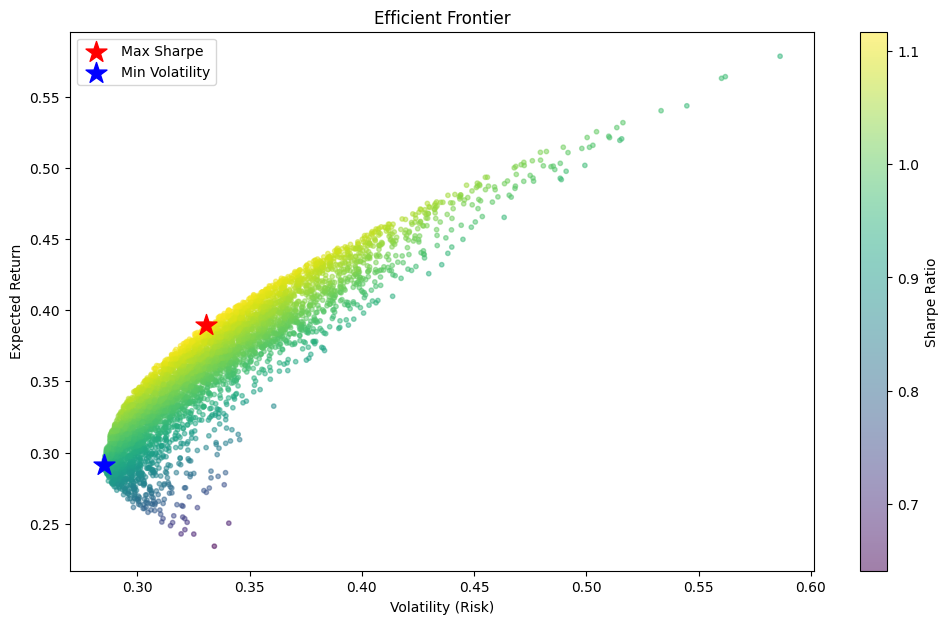

In [60]:
# 9. Plot Efficient Frontier
# -----------------------------
plt.figure(figsize=(12,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# Optimal points
plt.scatter(sharpe_volatility, sharpe_return, c='red', marker='*', s=250, label='Max Sharpe')
plt.scatter(vol_volatility, vol_return, c='blue', marker='*', s=250, label='Min Volatility')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()


In [61]:
# 10. Display Optimal Weights
# -----------------------------
def display_portfolio(weights, title):
    df = pd.DataFrame({'Stock': tickers, 'Weight': weights})
    print(f"\n{title} Allocation:")
    print(df)
    p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    print(f"Expected Annual Return: {p_return:.2%}")
    print(f"Annual Volatility: {p_volatility:.2%}")

display_portfolio(sharpe_weights, "Max Sharpe Portfolio")
display_portfolio(vol_weights, "Min Volatility Portfolio")



Max Sharpe Portfolio Allocation:
  Stock        Weight
0  AAPL  2.805834e-01
1  MSFT  1.289116e-16
2  TSLA  4.464249e-01
3  AMZN  2.729917e-01
Expected Annual Return: 38.96%
Annual Volatility: 33.06%

Min Volatility Portfolio Allocation:
  Stock        Weight
0  AAPL  3.474446e-01
1  MSFT  1.677480e-01
2  TSLA  4.848074e-01
3  AMZN  1.301043e-18
Expected Annual Return: 29.15%
Annual Volatility: 28.50%


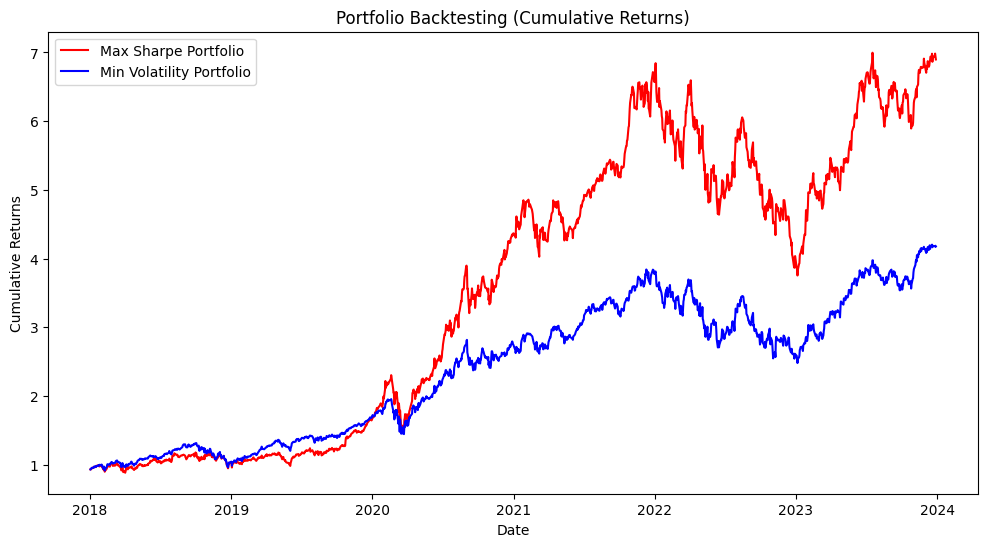

In [62]:
# 11. Backtesting
# -----------------------------
def backtest_portfolio(weights, returns, transaction_cost=0.001):
    weights = np.array(weights)
    daily_returns = (returns * weights).sum(axis=1)

    # Simple backtest without rebalancing for simplicity
    cumulative = (1 + daily_returns).cumprod()

    # Transaction cost impact if we rebalance monthly
    rebalance_freq = 21  # approx monthly
    cumulative_cost = 1.0
    for i in range(0, len(returns), rebalance_freq):
        cumulative_cost *= (1 - transaction_cost)
    cumulative *= cumulative_cost

    return cumulative

sharpe_cum = backtest_portfolio(sharpe_weights, returns)
vol_cum = backtest_portfolio(vol_weights, returns)

plt.figure(figsize=(12,6))
plt.plot(sharpe_cum, label='Max Sharpe Portfolio', color='red')
plt.plot(vol_cum, label='Min Volatility Portfolio', color='blue')
plt.title('Portfolio Backtesting (Cumulative Returns)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()